## Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

2023-01-06 18:13:25.491982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters

In [2]:
TRAIN_DIR = "./Data/seg_train"
TEST_DIR = "./Data/seg_test"

DIRECTORY_NAMES = [dir_name for dir_name in next(os.walk(TRAIN_DIR))][1]

genre_dict = {"buildings":0,"forest":1,"glacier":2,"mountain":3,"sea":4,"street":5}

BATCH_SIZE = 32
IMAGE_SIZE = (32,32) # resize the images
SEED = 128
VALIDATION_SPLIT = 0.2

EPOCHS = 50

## Load Data

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
        directory = TRAIN_DIR,
        labels = "inferred",                  # labels are generated from the directory structure
        label_mode = "categorical",           # labels are encoded as a categorical vector
        class_names = DIRECTORY_NAMES,        # Control the order of the classes
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        seed = SEED,
        validation_split = VALIDATION_SPLIT,  # Split the data in validation and training set
        subset = "training"
)

val_ds = keras.utils.image_dataset_from_directory(
        directory = TRAIN_DIR,
        labels = "inferred",                  # labels are generated from the directory structure
        label_mode = "categorical",           # labels are encoded as a categorical vector
        class_names = DIRECTORY_NAMES,        # Control the order of the classes
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        seed = SEED,
        validation_split = VALIDATION_SPLIT,  # Split the data in validation and training set
        subset = "validation"
)

test_ds = keras.utils.image_dataset_from_directory(
        directory = TEST_DIR,
        labels = "inferred",                  # labels are generated from the directory structure
        label_mode = "categorical",           # labels are encoded as a categorical vector
        class_names = DIRECTORY_NAMES,        # Control the order of the classes
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        seed = SEED,
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


2023-01-06 18:13:32.161254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [4]:
import pandas as pd
dataset_unbatched = tuple(test_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(np.argmax(label.numpy()))
labels = pd.Series(labels)
count = labels.value_counts()
print(count.sort_index())
print(sum(count))

0    474
1    437
2    553
3    501
4    525
5    510
dtype: int64
3000


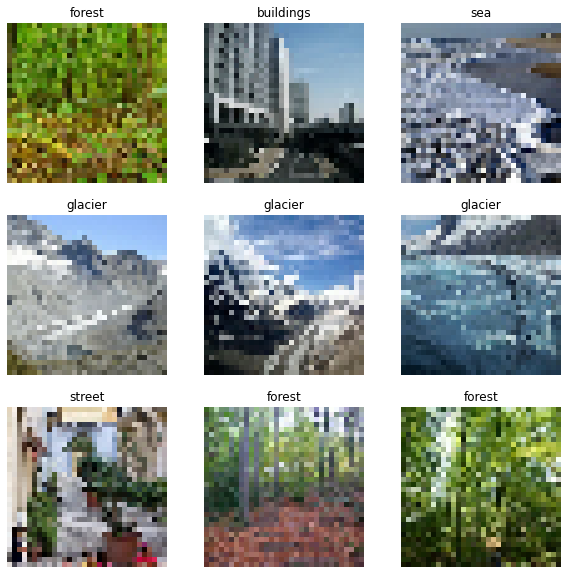

In [5]:
import matplotlib.pyplot as plt
import numpy as np
 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32, 6)


## Improve Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build and Compile the Model

In [10]:
### NORMALIZEE IMAGEEEEE##########


lambda1 = 5e-6
lambda2 = 5e-4

inputs = keras.Input(shape = (32, 32, 3))


output = keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = "relu", kernel_regularizer = keras.regularizers.L1L2(l1=lambda1, l2=lambda2))(inputs)
#output = keras.layers.BatchNormalization()(output)
output = keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1))(output)

output = keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = "relu", kernel_regularizer = keras.regularizers.L1L2(l1=lambda1, l2=lambda2))(output)
#output = keras.layers.BatchNormalization()(output)
output = keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1))(output)

output = keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), activation = "relu", kernel_regularizer = keras.regularizers.L1L2(l1=lambda1, l2=lambda2))(output)
#output = keras.layers.BatchNormalization()(output)
          

output = keras.layers.Flatten()(output)
#output = keras.layers.BatchNormalization()(output)

#output = keras.layers.Dense(300, activation='relu', kernel_regularizer = keras.regularizers.L1L2(l1=lambda1, l2=lambda2))(output)
#output = keras.layers.Dropout(0.5)(output)
#output = keras.layers.BatchNormalization()(output)

#output = keras.layers.Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1L2(l1=lambda1, l2=lambda2))(output)
#output = keras.layers.Dropout(0.5)(output)
#output = keras.layers.BatchNormalization()(output)

output = keras.layers.Dense(len(DIRECTORY_NAMES), activation='softmax')(output)


model = keras.Model(inputs = inputs, outputs = output)

model.compile(
    optimizer = keras.optimizers.Adam(0.001),
    #optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0),
    #optimizer = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)        1849

## Train the Model

In [9]:
checkpoint_filepath = "./Keras_Model/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True)

es = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

callback_list = [model_checkpoint_callback]


history = model.fit(
          train_ds,
          validation_data = val_ds,
          epochs = 5,
          callbacks = callback_list
    )

Epoch 1/5
351/351 [==============================] - 26s 70ms/step - loss: 1.4913 - accuracy: 0.4646 - val_loss: 1.1755 - val_accuracy: 0.5930
Epoch 2/5
351/351 [==============================] - 6s 17ms/step - loss: 1.1238 - accuracy: 0.6004 - val_loss: 0.9786 - val_accuracy: 0.6625
Epoch 3/5
351/351 [==============================] - 6s 16ms/step - loss: 1.0243 - accuracy: 0.6401 - val_loss: 0.9484 - val_accuracy: 0.6654
Epoch 4/5
351/351 [==============================] - 5s 16ms/step - loss: 0.9604 - accuracy: 0.6665 - val_loss: 0.9735 - val_accuracy: 0.6386
Epoch 5/5
351/351 [==============================] - 5s 16ms/step - loss: 0.9086 - accuracy: 0.6873 - val_loss: 0.8996 - val_accuracy: 0.6778


## Test the Model

In [10]:
Evaluation = model.evaluate(test_ds)

94/94 [==============================] - 5s 47ms/step - loss: 0.9116 - accuracy: 0.6830


In [13]:
save_model_name = f"./Keras_Model/ACC_{int(100*Evaluation[1])}_%"
model.save(save_model_name + ".h5")
#model.load_weights('cnn.h5')

## Save Test as Numpy Array

In [14]:
from keras import tfds 

ds_numpy = tfds.as_numpy(test_ds)  # Convert `tf.data.Dataset` to Python generator
for ex in ds_numpy:
    # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
    print(ex)
    break

ImportError: cannot import name 'tfds' from 'keras' (/Users/vinz/opt/anaconda3/lib/python3.9/site-packages/keras/__init__.py)

## Plot History

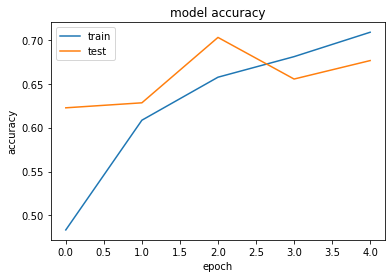

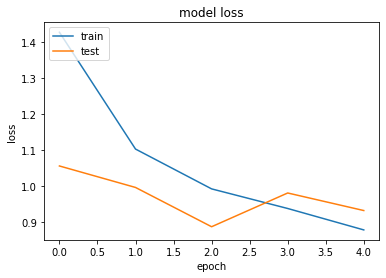

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [12]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
